In [1]:
%matplotlib inline
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler

#!pip install imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.metrics import accuracy_score,recall_score
from scipy.spatial import distance

In [2]:
df1 = pd.read_csv("LSDS_Recruiting_Task_InputData.csv")

# Data Exploration

In [3]:
#Pandas Profiling Exploratory Report
#profile = ProfileReport(df1, title="Pandas Profiling Report")
#profile

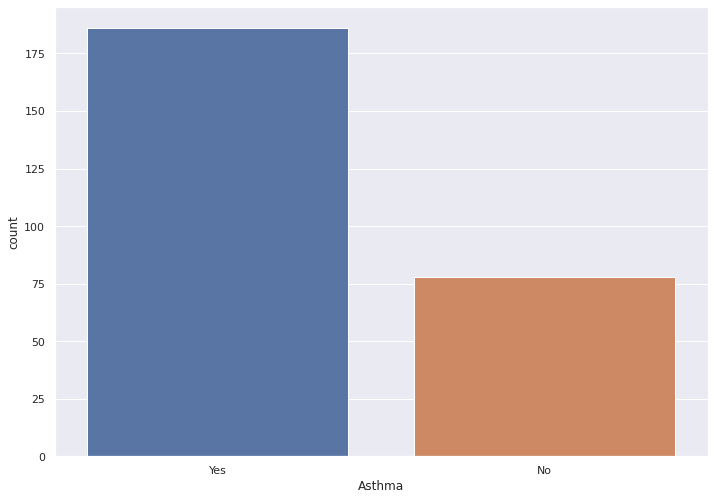

In [4]:
#Imbalanced Data
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=df1.drop_duplicates(subset=["Patient_ID"]),x="Asthma") 

In [5]:
print(df1.isnull().sum()) #No Missing values

df1.describe() #Looking at the min/max values of each feeature there seam to be no extrem outliers/inconistencies (e.g. age > 150 or height < 120)

Patient_ID      0
Gender          0
Age             0
Smoke           0
Height_Cm       0
Asthma          0
Day_ID          0
AsthmaAttack    0
PEF             0
FEV1            0
FVC             0
dtype: int64


,Age,Height_Cm,Day_ID,AsthmaAttack,PEF,FEV1,FVC
count,59136.000000,59136.000000,59136.000000,59136.000000,59136.000000,59136.000000,59136.000000
mean,48.291667,170.984848,112.500000,0.002976,492.066005,3.164645,4.021530
std,20.568108,9.160669,64.663133,0.054474,57.310658,0.742668,0.867348
min,15.000000,152.000000,1.000000,0.000000,170.720000,0.858000,0.875000
25%,29.750000,163.000000,56.750000,0.000000,452.247750,2.652000,3.405000
50%,47.500000,172.000000,112.500000,0.000000,490.895000,3.123000,3.873000
75%,66.000000,178.250000,168.250000,0.000000,532.551250,3.720000,4.799000
max,84.000000,189.000000,224.000000,1.000000,650.528000,4.715000,5.662000


# Data Preprocessing

In [6]:
AsthmaAttack = df1.pop("AsthmaAttack")
Day_ID = df1.pop("Day_ID")
df1.set_index("Patient_ID",inplace=True) #Patient_ID is an arbitrary number, thus has no discrimination power. Will use it as an index

string = ["Smoke","Asthma","Gender"] 

df1 = df1.groupby("Patient_ID").median().join(df1.groupby(df1.index).first()[string]) #Convert Time Series to static persepctive with the average Measurements

## Feature Engineering



In [7]:
#These are PEF values the patients should normally have based on their Age, Height and Gender
df1.loc[df1.Gender == "Male","comparePEF"] =  (((df1.loc[df1.Gender == "Male"].Height_Cm * 0.0548) + 1.58) - (df1.loc[df1.Gender == "Male"].Age * 0.041)) * 60
df1.loc[df1.Gender == "Female","comparePEF"] =  (((df1.loc[df1.Gender == "Female"].Height_Cm * 0.0372) + 2.24) - (df1.loc[df1.Gender == "Female"].Age * 0.03)) * 60
df1.loc[df1.Age < 18,"comparePEF"] =  ((df1.loc[df1.Age < 18 ].Height_Cm - 100 ) * 5) + 100

df1["PEF_ratio"] = df1.PEF / df1.comparePEF


#FEV1_FVC_ratio
df1.loc[:,"FEV1_FVC_ratio"] = df1.FEV1 / df1.FVC #The Global Initiative for Asthma defines asthma by combining variable respiratory symptoms with variable expiratory airflow limitation, expressed as an FEV1/FVC ratio less than 75-80% (7)


In [8]:
X = df1[["FEV1_FVC_ratio","PEF_ratio"]]
y = df1.Asthma

## Visualizations for Feature Selection 

In [9]:
df1[["FEV1_FVC_ratio","PEF_ratio","Asthma"]]

,FEV1_FVC_ratio,PEF_ratio,Asthma
Patient_ID,,,
ROA376C0191000,0.690187,0.884411,Yes
ROA376C0191001,0.741354,1.020148,Yes
ROA376C0191002,0.756418,1.026028,No
ROA376C0191003,0.739401,1.000023,Yes
ROA376C0191004,0.750196,1.277153,Yes
...,...,...,...
ROD379B9561021,0.900643,1.151963,No
ROD379B9561022,0.755451,1.016313,Yes
ROD379B9561023,0.836606,1.061538,Yes


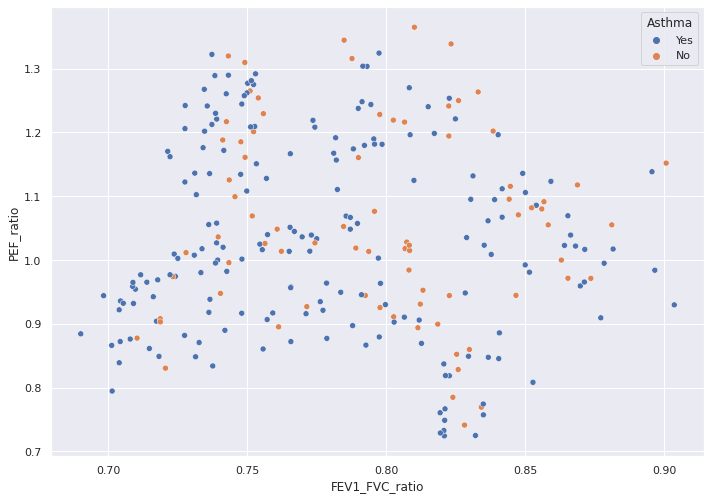

In [10]:
sns.scatterplot(data = df1[["FEV1_FVC_ratio","PEF_ratio","Asthma"]],x = "FEV1_FVC_ratio", y = "PEF_ratio",hue = "Asthma")
plt.show()

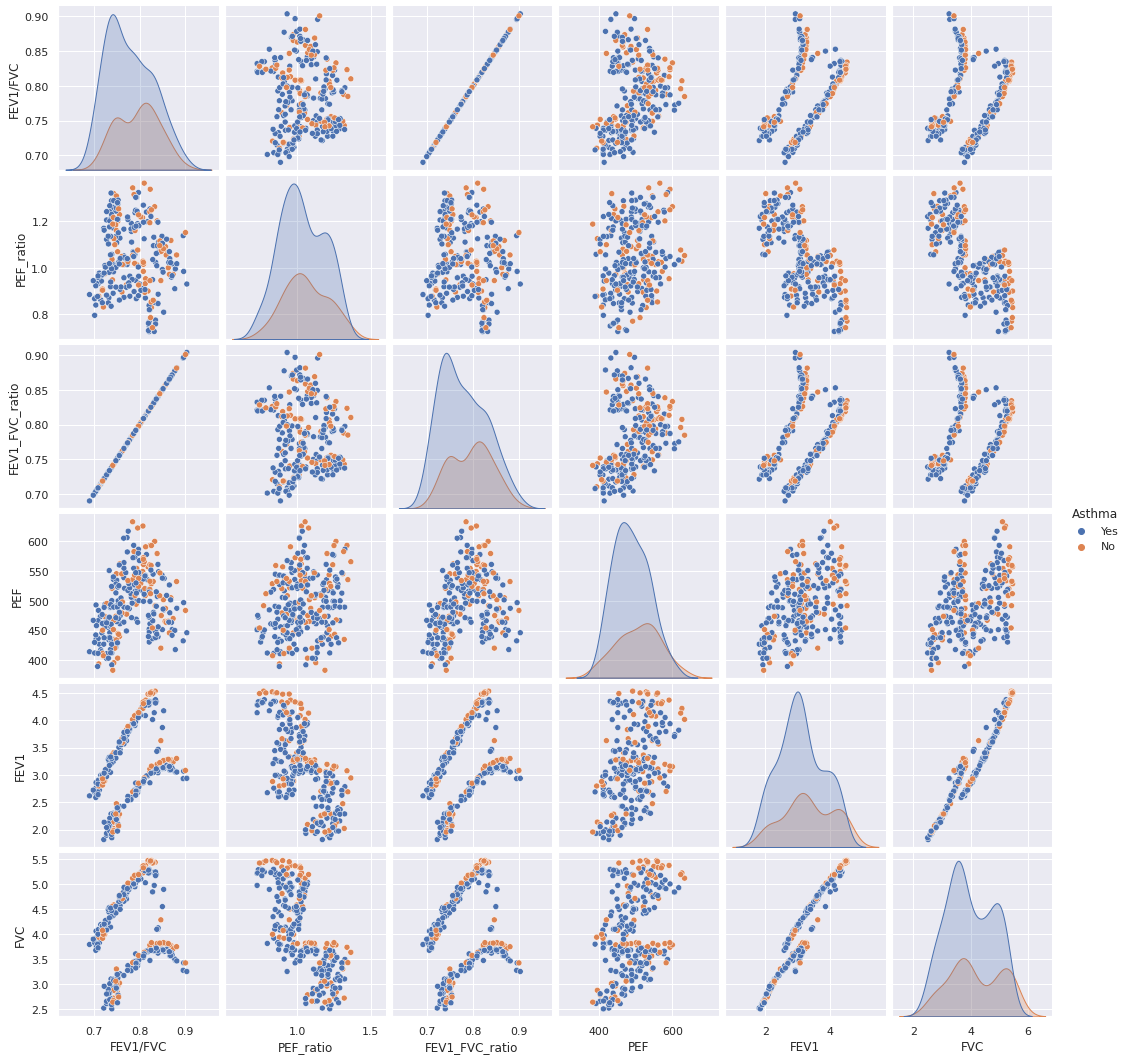

In [11]:
df1["FEV1/FVC"] = df1.FEV1 / df1.FVC

sns.pairplot(df1[["FEV1/FVC","PEF_ratio","FEV1_FVC_ratio","PEF","FEV1","FVC","Asthma"]],hue="Asthma")
plt.show()

## Oversampling

As shown in the Data Exploration we have more than twice as many patience with Asthma than patience without Asthma in our dataset. ML Models trained on an imbalanced Dataset will be biased towards the majority class. To overcome this problem I synthetically generate new patient that do not have Astmha until a balancy is reached.

In [12]:

#SMOTE Oversampling
sm = SMOTE(random_state=1)
X, y = sm.fit_resample(X, y)
y = y.astype("category").cat.codes

## Model 1

In [13]:
#Modelling. Build and post-prune Decision Tree

from sklearn import tree
from sklearn.model_selection import cross_val_score

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)


#Post-Pruning with cost-complexity alpha
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

scores = dict()
for alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=alpha)
    clf.fit(X, y)
    scores[alpha] = cross_val_score(clf, X, y, cv=50, scoring="recall").mean()

In [14]:
#Final tree
clf = tree.DecisionTreeClassifier(ccp_alpha=max(scores, key=scores.get))
clf.fit(X, y)
print("Predictions: \n",pd.Series(clf.predict(X)).value_counts())
print("Accuracy",cross_val_score(clf, X, y, cv=50, scoring="accuracy").mean())
print("Recall",max(scores.values()))


Predictions: 
 1    225
0    147
dtype: int64
Accuracy 0.6453571428571427
Recall 0.705


## Model 2 (Proba of Asthma Attak in next two days)



In [15]:
df2 = pd.read_csv("LSDS_Recruiting_Task_InputData.csv")
df2 = df2[df2.Asthma == "Yes"] #Select only Asthma patients


In [16]:
df2 = df2.merge(df2.groupby("Patient_ID")[["PEF","FEV1"]].max().reset_index(),on="Patient_ID",suffixes=('', '_best')) #Add a new feature with the best PEF for each patient


In [17]:
df2["Attack_in_1day"] = df2["AsthmaAttack"].shift(-1)
df2["Attack_in_2day"] = df2["AsthmaAttack"].shift(-2)

df2.loc[df2.Day_ID == 224,["Attack_in_1day","Attack_in_2day"]] = np.nan
df2.loc[df2.Day_ID == 223,["Attack_in_2day"]] = 0

df2["target"] = np.where(df2.Attack_in_1day + df2.Attack_in_2day >= 1,1,0) # This feature shows the occurence of an Attack in one *or* two days

#currentPEF / bestPEF
df2["PEF_current/best"] = df2.PEF / df2.PEF_best
df2["FEV1_current/best"] = df2.FEV1 / df2.FEV1_best


In [18]:
df1.loc[df1.Gender == "Male","expected_FEV1"] = (df1.Height_Cm * 0.043) - (df1.Age * 0.029) -2.49
df1.loc[df1.Gender == "Female","expected_FEV1"] = (df1.Height_Cm * 0.0395) - (df1.Age * 0.025) -2.6
df1["FEV1_ratio"] = df1.FEV1 / df1.expected_FEV1

df2 = df2.merge(df1["FEV1_ratio"].reset_index(),on="Patient_ID")


The following figure indicate that the FEV1_ratio is not very discriminative. However, both the PEF- and FEV1- current/best are found to be highly relevant and thus will be used for prediction.

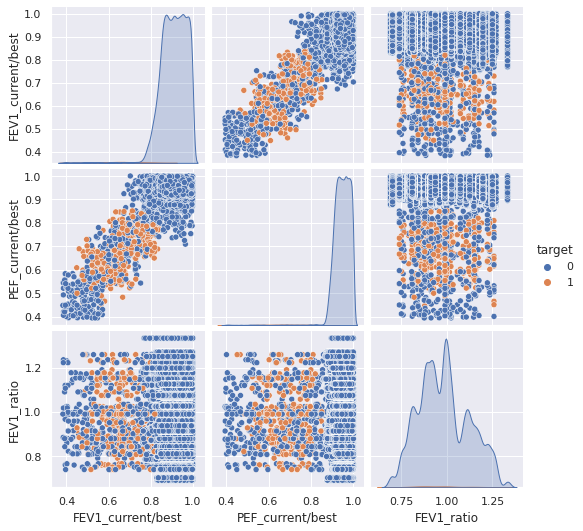

In [19]:
X = df2.set_index("Patient_ID")[["FEV1_current/best","PEF_current/best"]]
y = df2.target

sns.pairplot(df2[["FEV1_current/best","PEF_current/best","FEV1_ratio","target"]],hue="target")
plt.show()



## Two approches to compute a probabilty from the KNN 

## 1. approach

In [20]:
# Calculate the distances from all datapoints to the datapoints that represent an Asthma Attack

to_target = df2[df2["target"] == 1][["FEV1_current/best","PEF_current/best"]]

dist = distance.cdist(X, to_target, 'euclidean')

In [21]:
#Calculate the k neigherst neighbors with target = 1 and then calculate the average distance to them. 
#Idea: The further away Asthma-Attack points are, the less likely an Attack is.

dist.sort(axis=1)
k = 3
X_dist = pd.DataFrame(dist).iloc[:,:k].mean(axis=1)
X_dist = np.array(X_dist).reshape(-1, 1)


# Convert average distances to probabilties using Logistic Regression
log_reg = LogisticRegression(random_state=0).fit(X_dist, y)
predictions1 = log_reg.predict_proba(X_dist)

predictions1 = pd.DataFrame(predictions1)[1]
predictions1





0        0.001278
1        0.002540
2        0.001869
3        0.001834
4        0.000612
           ...   
41659    0.000804
41660    0.002336
41661    0.001184
41662    0.002487
41663    0.000821
Name: 1, Length: 41664, dtype: float64

## 2. approach

In [22]:
#Alternative: KNN Classification and then determine Probabilty = Number of K Nearest Neighbor with target = 1 / K (Drawback: Most of the probabitlies would be zero)

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X, y)
print("Recall ",cross_val_score(knn, X, y, cv=30, scoring="recall").mean())

predictions2 = pd.DataFrame(knn.predict_proba(X),index=X.index)[1]

#Patients that have a relatively high probabilty of an upcoming Asthma Attack. They should take preventive medicine.
predictions2[predictions2 > 0.2]



Recall  0.6530303030303031


Patient_ID
ROA376C0191000    0.857143
ROA376C0191000    0.714286
ROA376C0191000    0.428571
ROA376C0191000    0.571429
ROA376C0191000    0.714286
                    ...   
ROD379B9561022    0.714286
ROD379B9561022    0.428571
ROD379B9561022    0.857143
ROD379B9561022    0.571429
ROD379B9561022    0.428571
Name: 1, Length: 583, dtype: float64